In [76]:
import torch
from torch.utils.data import Dataset
import pickle
import string

In [77]:
from mininlp.data import Tokenizer

tokenizer = Tokenizer()

In [78]:
"""Token are every ascii character and special tokens for start of sentence, 
end of sentence, padding, unknown and mask."""
from mininlp.data import assci_tokens
print(assci_tokens())

{'p', '&', 'r', 's', ']', '\x0b', '.', '\r', '0', '_', 'Z', '\x0c', 'x', 'j', '>', 'H', '+', '(', 'v', 'F', 'G', 'V', 'A', 'U', '^', 'Y', '|', 't', 'y', 'm', '1', "'", ':', 'N', '?', ';', '<', '[', 'R', 'S', 'o', 'e', '9', ' ', '4', '<eos>', '\\', 'C', ')', '%', 'k', '#', 'w', 'E', '-', '\n', '3', '7', 'q', '8', 'M', 'Q', '<unk>', '<mask>', 'b', 'h', '`', 'L', 'g', '5', 'D', 'P', '}', '!', '=', '"', '\t', 'c', 'f', 'n', '@', '/', '$', 'O', 'K', 'a', 'd', 'u', 'W', '*', '{', 'l', '<sos>', 'B', 'I', '<pad>', 'X', '2', 'J', ',', 'i', 'T', 'z', '~', '6'}


In [79]:
tokens = assci_tokens()
tokenizer = Tokenizer(tokens)

In [80]:
"""Test if the tokenizer is able to convert tokens to ids and vice versa."""

for id in tokenizer._tokens:
    assert tokenizer._token_ids[tokenizer._tokens[id]] == id

In [81]:
"""Test if the tokenizer is able to encode and decode a string."""

test_string = "Hello, World! \nLovely day, isn't it?"

test_encoded = tokenizer.encode(test_string)
test_decoded = tokenizer.decode(test_encoded)
assert test_string == "".join(test_decoded)

print(test_string)
print(test_encoded)
print(test_decoded)

Hello, World! 
Lovely day, isn't it?
tensor([ 15,  41,  91,  91,  40,  99,  43,  88,  40,   2,  91,  86,  73,  43,
         55,  67,  40,  18,  41,  91,  28,  43,  86,  85,  28,  99,  43, 100,
          3,  79,  31,  27,  43, 100,  27,  34], dtype=torch.int32)
['H', 'e', 'l', 'l', 'o', ',', ' ', 'W', 'o', 'r', 'l', 'd', '!', ' ', '\n', 'L', 'o', 'v', 'e', 'l', 'y', ' ', 'd', 'a', 'y', ',', ' ', 'i', 's', 'n', "'", 't', ' ', 'i', 't', '?']


In [82]:
"""Test if the tokenizer is able to save and load itself."""

tokenizer.save("tokenizer")

tokenizer2 = Tokenizer()
tokenizer2.load("tokenizer.pkl")

In [83]:
"""Test if the loaded tokenizer is the same as the original tokenizer."""

assert tokenizer._tokens == tokenizer2._tokens
assert tokenizer._token_ids == tokenizer2._token_ids

In [84]:
"""Test if the orginal tokenizer and the loaded one encodes and decodes a string to the same tokens ids."""

test_encoded = tokenizer2.encode(test_string)
test_decoded = tokenizer.decode(test_encoded)
assert test_string == "".join(test_decoded)

test_encoded = tokenizer.encode(test_string)
test_decoded = tokenizer2.decode(test_encoded)
assert test_string == "".join(test_decoded)

print(test_decoded)
print(test_encoded)

['H', 'e', 'l', 'l', 'o', ',', ' ', 'W', 'o', 'r', 'l', 'd', '!', ' ', '\n', 'L', 'o', 'v', 'e', 'l', 'y', ' ', 'd', 'a', 'y', ',', ' ', 'i', 's', 'n', "'", 't', ' ', 'i', 't', '?']
tensor([ 15,  41,  91,  91,  40,  99,  43,  88,  40,   2,  91,  86,  73,  43,
         55,  67,  40,  18,  41,  91,  28,  43,  86,  85,  28,  99,  43, 100,
          3,  79,  31,  27,  43, 100,  27,  34], dtype=torch.int32)


In [85]:
from mininlp.data import SequenceDataset

encoded_document = tokenizer.tokenize_document("../data/anna.txt")
dataset = SequenceDataset('../data/anna.txt', tokenizer, 32, 1000)

In [86]:
dataset[0]

(tensor([95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
         95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 92, 79, 40, 18],
        dtype=torch.int32),
 tensor(100, dtype=torch.int32))

In [87]:
print(tokenizer.decode(dataset[50][0]), tokenizer.decode(dataset[50][1]))
print(tokenizer.decode(dataset[46][0]), tokenizer.decode(dataset[46][1]))
print(tokenizer.decode(dataset[5][0]), tokenizer.decode(dataset[5][1]))

['<pad>', '<pad>', '<pad>', '<pad>', '<sos>', 'd', ',', '\n', 'l', 'o', 'o', 'k', 'i', 'n', 'g', ' ', 'r', 'o', 'u', 'n', 'd', ' ', 'a', 't', ' ', 'h', 'e', 'r', '.', '\n', '\n', '"'] ['O']
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<sos>', 'r', 't', ' ', 'o'] ['f']
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<sos>', 'f', ' ', 'h', 'i', 's', ' ', 'n', 'o', 't', 'e', 'b', 'o', 'o'] ['k']


# Model

In [88]:
from mininlp.transformer import DTransformer
import json

VERSION = 1
MODEL_NAME = f'decoder_transformer_v{VERSION}'
config = json.load(open(f"../models/{MODEL_NAME}.json"))

model = DTransformer(
    config['layers'], 
    config['embedding_dim'], 
    len(tokenizer), 
    config['seq_len'], 
    config['heads'], 
    config['factor'])
state_dict = torch.load(f"../models/{MODEL_NAME}.pt")
model.load_state_dict(state_dict)
model.to('cuda')

DTransformer(
  (_embedding): Embedding(
    (_token_embedding): Embedding(105, 512)
  )
  (_decoders): ModuleList(
    (0-3): 4 x Decoder(
      (_laynorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (_laynorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (_mmha): MultiHeadAttention(
        (_projection): ModuleList(
          (0-2): 3 x Linear(in_features=512, out_features=512, bias=True)
        )
        (_reprojection): Linear(in_features=512, out_features=512, bias=True)
      )
      (_mha): MultiHeadAttention(
        (_projection): ModuleList(
          (0-2): 3 x Linear(in_features=512, out_features=512, bias=True)
        )
        (_reprojection): Linear(in_features=512, out_features=512, bias=True)
      )
      (_ff): FeedForward(
        (_laynorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (_ff): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Li

In [89]:
tokenizer = Tokenizer()
tokenizer.load("../models/tokenizer.pkl")
dataset = SequenceDataset('../data/anna.txt', tokenizer, config['seq_len'], 1)

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
) missing from current font.es/IPython/core/pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


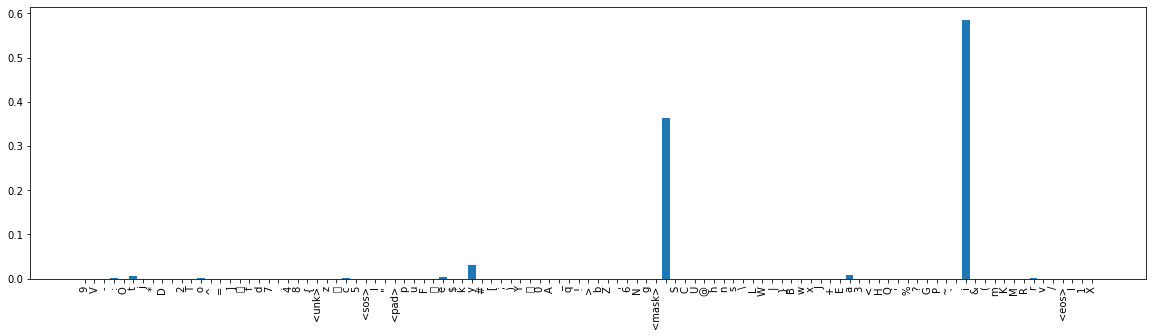

In [90]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    input = dataset[0][0].unsqueeze(0)
    output = model(input.to('cuda'))
    probs = F.softmax(output[0, -1, :], dim=0)
    probs = probs.detach().cpu()
    
plt.figure(figsize=(20, 5))
plt.bar(tokenizer.decode(torch.tensor(range(len(probs)))), probs)
plt.xticks(rotation=90)
plt.show()

In [91]:
text = tokenizer.decode(dataset[0][0])
text += ["<msk>"]
model.eval()
with torch.no_grad():
    prompt = dataset[0][0].unsqueeze(0).to('cuda')
    text += tokenizer.decode(model.generate(prompt, 1000))

In [92]:
text = [t for t in text if t != "<pad>"]
print("".join(text))

<sos>he
came to him, and without waiting to be announced, walked straight into
his study. She found him as he was sitt<msk> worrring tand in geat t traing
tand way stt the had of ther peat tred him at ha fed him acre inted
that all-----------that's lall----hainte ma----it tra-----just ta
faus as ta
mualfta allfe awas couste. What inte explain ware of tall a qualll off ther
he wand woulte-chaintion which is it inquite; but liqulitteristing tat
wainted inter of her it all the whow ain the ha parie the parie that it Gof.

"Yes, perfe gran he hawhere frat that inquite--------chainte it mea
fauare wae inquite ftashe hainte; in whered but he page in he hand way,
he hand would haLed.



Che ftagof tret bling tat t alone ting ttt t the gett be it in ther what
main ceass itt fout, buty's coly ou being inting wass htt there it inter
heare were him, the went inquite; in; the inter ight her it wof-----shla
felthe fit's chaion's, where, he htrees ittting how ther thing but sea
muquall the creet was